In [16]:
!pip install ultralytics

In [17]:
from google.colab import drive
import cv2
import os
import math
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [18]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
def create_directories(base_path):
    os.makedirs(f"{base_path}/train/box", exist_ok=True)
    os.makedirs(f"{base_path}/train/cone", exist_ok=True)
    os.makedirs(f"{base_path}/val/box", exist_ok=True)
    os.makedirs(f"{base_path}/val/cone", exist_ok=True)


def find_video_file(folder_path, file_prefix):
    possible_extensions = ['.mp4', '.mov']
    file_prefix_lower = file_prefix.lower()

    for file in os.listdir(folder_path):
        for ext in possible_extensions:
            if file.lower() == f"{file_prefix_lower}{ext}":
                return os.path.join(folder_path, file)
    return None


In [20]:
def save_frame(image, output_dir, prefix, count):
    file_name = os.path.join(output_dir, f"{count:04d}_{prefix}.png")
    cv2.imwrite(file_name, image)

def split_frames(video_path, base_output_dir, prefix, frames_per_second=5, split_ratio=0.8):
    vidcap = cv2.VideoCapture(video_path)

    if not vidcap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return

    fps = int(vidcap.get(cv2.CAP_PROP_FPS))
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Frames per second: {fps}")
    print(f"Total frames in video: {total_frames}")

    frame_interval = int(fps / frames_per_second)

    total_extracted_frames = total_frames // frame_interval

    train_frame_limit = math.ceil(total_extracted_frames * split_ratio)

    count = 0
    success, image = vidcap.read()
    frame_number = 0

    while success:
        if frame_number % frame_interval == 0:
            if count < train_frame_limit:
                output_dir = f"{base_output_dir}/train/{prefix}"
            else:
                output_dir = f"{base_output_dir}/val/{prefix}"

            save_frame(image, output_dir, prefix, count)
            count += 1

        success, image = vidcap.read()
        frame_number += 1

    vidcap.release()

In [21]:
def process_single_video(base_path, base_output_dir, file_prefix, frames_per_second=10, split_ratio=0.8):
    video_path = find_video_file(base_path, file_prefix)

    if video_path:
        print(f"Found video file: {video_path}")

        create_directories(base_output_dir)

        split_frames(video_path, base_output_dir, file_prefix, frames_per_second, split_ratio)
    else:
        print(f"Error: Video file for {file_prefix} not found.")
base_output_dir = "Data"
base_path = '/content/drive/MyDrive/RAI_CAMP_DATASET'

process_single_video(base_path, base_output_dir, 'box')
process_single_video(base_path, base_output_dir, 'cone')
print("Frame extraction and splitting into train/val completed.")

Found video file: /content/drive/MyDrive/RAI_CAMP_DATASET/Box.mp4
Frames per second: 26
Total frames in video: 141
Found video file: /content/drive/MyDrive/RAI_CAMP_DATASET/Cone.mp4
Frames per second: 28
Total frames in video: 148
Frame extraction and splitting into train/val completed.


In [22]:
model = YOLO('yolov8n-cls.pt')
model.train(data='/content/Data', epochs=5)

Ultralytics 8.3.11 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/Data, epochs=5, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

train: Scanning /content/Data/train... 116 images, 0 corrupt: 100%|██████████| 116/116 [00:00<?, ?it/s]
val: Scanning /content/Data/val... 29 images, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)


TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/classify/train5
Starting training for 5 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

                   all      0.517          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]

                   all          1          1



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/classify/train5/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train5/weights/best.pt, 3.0MB

Validating runs/classify/train5/weights/best.pt...
Ultralytics 8.3.11 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 73 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/Data/train... found 116 images in 2 classes ✅ 
val: /content/Data/val... found 29 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


                   all          1          1
Speed: 0.0ms preprocess, 18.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train5
Results saved to runs/classify/train5


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x793027e56530>
curves: []
curves_results: []
fitness: 1.0
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 1.0, 'metrics/accuracy_top5': 1.0, 'fitness': 1.0}
save_dir: PosixPath('runs/classify/train5')
speed: {'preprocess': 0.0011016582620554957, 'inference': 17.993927001953125, 'loss': 0.0001315412850215517, 'postprocess': 0.00010687729408001078}
task: 'classify'
top1: 1.0
top5: 1.0

In [23]:
def perform_inference(model, image_path):
    image = cv2.imread(image_path)

    results = model(image_path)

    predicted_class = results[0].names[results[0].probs.top1]
    confidence = results[0].probs.top1conf.item()

    display_image_with_prediction(image, predicted_class, confidence)

def display_image_with_prediction(image, predicted_class, confidence):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.title(f"Prediction: {predicted_class}, Confidence: {confidence*100:.2f}%")
    plt.axis('off')
    plt.show()

Processing image: /content/drive/MyDrive/RAI_CAMP_DATASET/TEST/IMG_20241013_200641.jpg

image 1/1 /content/drive/MyDrive/RAI_CAMP_DATASET/TEST/IMG_20241013_200641.jpg: 224x224 box 0.75, cone 0.25, 16.8ms
Speed: 112.2ms preprocess, 16.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


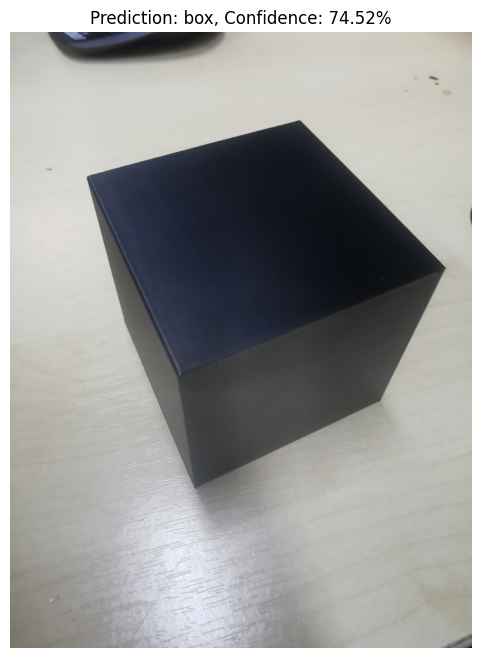

Processing image: /content/drive/MyDrive/RAI_CAMP_DATASET/TEST/IMG_20241013_200632.jpg

image 1/1 /content/drive/MyDrive/RAI_CAMP_DATASET/TEST/IMG_20241013_200632.jpg: 224x224 cone 0.74, box 0.26, 21.4ms
Speed: 112.4ms preprocess, 21.4ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 224)


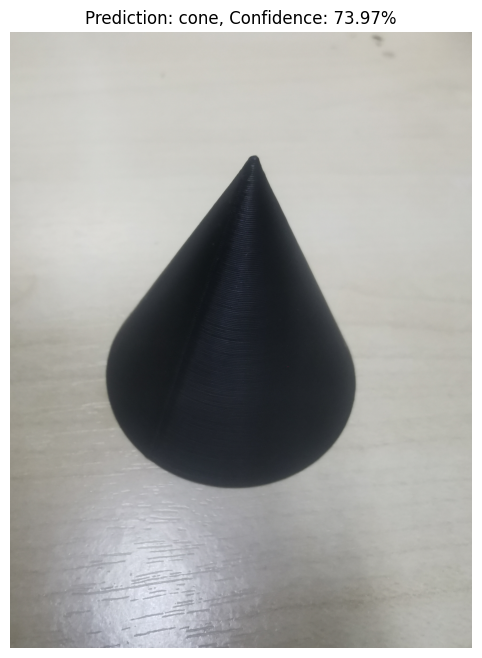

In [24]:
def process_images_in_folder(model, folder_path):
    supported_extensions = ('.png', '.jpg')

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(supported_extensions):
            image_path = os.path.join(folder_path, filename)
            print(f"Processing image: {image_path}")
            perform_inference(model, image_path)

test_folder_path = '/content/drive/MyDrive/RAI_CAMP_DATASET/TEST'

process_images_in_folder(model, test_folder_path)
